In [1]:
import math
import pandas as pd

import matplotlib.pyplot as plt

from PIL import Image
from statsbombpy import sb
from mplsoccer import VerticalPitch

In [2]:
df = sb.events(match_id=3847567).sort_values(by=['index'])

In [3]:
team1 = df[df.team == "England Women's"]

team2 = df[df.team == "Germany Women's"]

In [4]:
# Set a couple of constants for the colors
ENGLAND_COLOR = '#CF081F'  # Red from the St George's Cross
GERMANY_COLOR = '#000000'  # Black from the German flag
ENGLAND_TEAM_ID = 865
GERMANY_TEAM_ID = 857

In [5]:
# Removes penalty shoot-out
df = df[df.period < 5]

In [6]:
def create_shotmap(team, ax):
    pitch = VerticalPitch(pitch_type='statsbomb', half=True)
    pitch.draw(ax=ax)
    
    # the shots data is in the 'type' column
    team = team[team['type']=='Shot']
    
    # Filter down to just the columns we need
    team = team[['team', 'player', 'location', 'shot_outcome', 'shot_statsbomb_xg', 'shot_type']]
    team[['x', 'y']] = team['location'].apply(pd.Series)
    
    # Draw the shotmap
    for x in team.to_dict(orient='records'):
    
        pitch.scatter(
            x=x['x'], y=x['y'], ax=ax, 
            s=500 * x['shot_statsbomb_xg'], 
            color='green' if x['shot_outcome'] == 'Goal' else 'white', 
            edgecolors='black', alpha=0.7
        )

In [7]:
def create_passnetwork(team, ax):
    team[['x', 'y']] = team['location'].apply(pd.Series)
    
    tactics = team[~team['tactics'].isnull()][['tactics', 'team']]

    all_jersey_numbers = []
    for y in tactics.to_dict(orient='records'):
        all_jersey_numbers.append(pd.DataFrame([{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]))
        
    jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()
    
    # Make a new, single column for time and sort the events in chronological order
    team["newsecond"] = 60 * team["minute"] + team["second"]
    
    team.sort_values(by=['newsecond'])
    
    # identify the passer and then the recipient, who'll be the playerId of the next action
    team['passer'] = team['player_id']
    
    team['recipient'] = team['passer'].shift(-1)
    
    # filter for only passes and then successful passes
    passes_df = team.loc[(team['type']=="Pass")]
    passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
    
    completions = passes_df.loc[(passes_df['pass_outcome'] == "Successful")]
    
    #find time of the team's first substitution and filter the df to only passes before that
    sub_df = team.loc[(team['type'] == "Substitution")]
    first_sub = sub_df["newsecond"].min()
    
    if first_sub <= (60 * 45):
        first_sub = 60 * 45
    
    completions = completions.loc[completions['newsecond'] < first_sub]
    
    # Find Average Locations
    average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
    average_locs_and_count.columns = ['x', 'y', 'count']
    
    # find number of passes along each 'path' of passer to recipient
    passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
    passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)
    
    passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
    passes_between = passes_between.merge(
        average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
    )
    
    # set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
    passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]
    
    # plot arrows
    def pass_line_template(ax, x, y, end_x, end_y, line_color):
        ax.annotate(
            '',
            xy=(end_y,  end_x),
            xytext=(y, x),
            zorder=1,
            arrowprops=dict(arrowstyle='-|>', linewidth=4, color=line_color, alpha=.85)
        )
        
    def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2):
        dist = math.hypot(end_x - x, end_y - y)
        angle = math.atan2(end_y-y, end_x-x)
        upd_x = x + (dist - dist_delta) * math.cos(angle)
        upd_y = y + (dist - dist_delta) * math.sin(angle)
        pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color)
    
    pitch = VerticalPitch(pitch_type='statsbomb')
    pitch.draw(ax=ax)
    
    for index, row in passes_between.iterrows():
        pass_line_template_shrink(ax, row['x'], row['y'], row['x_end'], row['y_end'], 'black')
    
    
    # plot nodes
    pitch.scatter(
        average_locs_and_count.x, average_locs_and_count.y, s=500,
        color='#f0ece2', edgecolors="#010101", linewidth=2, alpha=1, ax=ax, zorder=2
    )
    
    for index, row in average_locs_and_count.iterrows():
        pitch.annotate(
            jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values[0],
            xy=(row.x, row.y),
            c='#132743',
            va='center',
            ha='center',
            size=10,
            fontweight='bold',
            ax=ax
        )

In [8]:
def create_table(team1, team2):
    team1 = team1[team1['pass_outcome'] != 'Unknown']
    team2 = team2[team2['pass_outcome'] != 'Unknown']
    
    stats = {
        'xG' : {'team1': round(team1['shot_statsbomb_xg'].sum(), 2), 'team2': round(team2['shot_statsbomb_xg'].sum(), 2)},
        'shots': {'team1': len(team1[team1['type'] == 'Shot']), 'team2': len(team2[team2['type'] == 'Shot'])},
        'shots_on_target' : {
            'team1': len(team1[(team1['type'] == 'Shot') & (team1['shot_end_location'].str.len() > 2) & (team1['shot_outcome'] != 'Off T')]), 
            'team2': len(team2[(team2['type'] == 'Shot') & (team2['shot_end_location'].str.len() > 2) & (team2['shot_outcome'] != 'Off T')])
        },
        'passes': {'team1': len(team1[team1['type'] == 'Pass']), 'team2': len(team2[team2['type'] == 'Pass'])},
        'pass_completion':{
            'team1': round(len(team1[(team1['type'] == 'Pass') & (team1['pass_outcome'].isna())]) / len(team1[team1['type'] == 'Pass']) * 100, 2) ,
            'team2': round(len(team2[(team2['type'] == 'Pass') & (team2['pass_outcome'].isna())]) / len(team2[team2['type'] == 'Pass']) * 100, 2)         
        }
    }
    
    stats_df = pd.DataFrame(stats).T
    
    column_labels = ['', '', '']
    table_vals = [
        [str(stats_df['team1']['xG']), 'xG', str(stats_df['team2']['xG'])],
        [str(stats_df['team1']['shots']), 'Shots', str(stats_df['team2']['shots'])],
        [str(stats_df['team1']['shots_on_target']), 'Shots on Target', str(stats_df['team2']['shots_on_target'])],
        [str(stats_df['team1']['passes']), 'Passes', str(stats_df['team2']['passes'])],
        [str(stats_df['team1']['pass_completion']), 'Pass Completion %', str(stats_df['team2']['pass_completion'])]
    ]
    
    return column_labels, table_vals

In [9]:
def create_xg_flow_chart(df, ax):
    # Use the original df instead of the team1 and team2 dataframes
    
    # Filter the columns to only shots
    df = df[df['type'] == 'Shot']
    
    # Sort the values so they are in order of time
    df = df.sort_values(by="index")
    
    # Calculate the cumulative xG for each team
    df['cumulative_xG'] = df.groupby('team_id')['shot_statsbomb_xg'].cumsum()
    
    # Plot the xG for each team by half
    # We want to make it so the lines both start at 0
    for team in df['team_id'].unique():
        
        team_df = df[df['team_id'] == team]
        
        # add a 0 xG row at the start of the match
        team_df = pd.concat([pd.DataFrame({
            'team_id': team, 'minute': 0, 'shot_statsbomb_xg': 0, 'shot_outcome': None, 'cumulative_xG': 0, 'period': 1
        }, index=[0]), team_df])
        
        ax.plot(
            team_df['minute'], 
            team_df['cumulative_xG'], 
            label=team, 
            drawstyle='steps-post',
            c=ENGLAND_COLOR if team == ENGLAND_TEAM_ID else GERMANY_COLOR
        )   
            
    
    # We Can add a scatter plot to show the goals
    for team in df['team_id'].unique():
        team_df = df[(df['team_id'] == team) & (df['shot_outcome'] == 'Goal')].to_dict(orient='records')
        for x in team_df:
            ax.scatter(
                x['minute'], 
                x['cumulative_xG'], 
                c='white',
                edgecolor=ENGLAND_COLOR if team == ENGLAND_TEAM_ID else GERMANY_COLOR,
                s=100,
                # We want the goals to be on top of the lines
                zorder=5
            )
            
            # add a label to the goals for the player who scored
            ax.text(
                x['minute'], 
                x['cumulative_xG'] - .07, 
                x['player'], 
                ha='center', 
                va='center', 
                fontfamily='monospace', 
                fontsize=8,
                zorder=10
            )
            
    # Let's label the x axis with first and second half
    ax.set_xticks([0, 45, 90, 120])
    ax.set_xticklabels(['0\'', '45\'', '90\'', '120\''])
    
    # Let's get rid of the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

/var/folders/07/r8vgl6rn1_qgfpx0lyfdffph0000gn/T/ipykernel_75179/3556403404.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
/var/folders/07/r8vgl6rn1_qgfpx0lyfdffph0000gn/T/ipykernel_75179/3556403404.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")


Text(0.5, 1.0, 'Germany Shot Map')

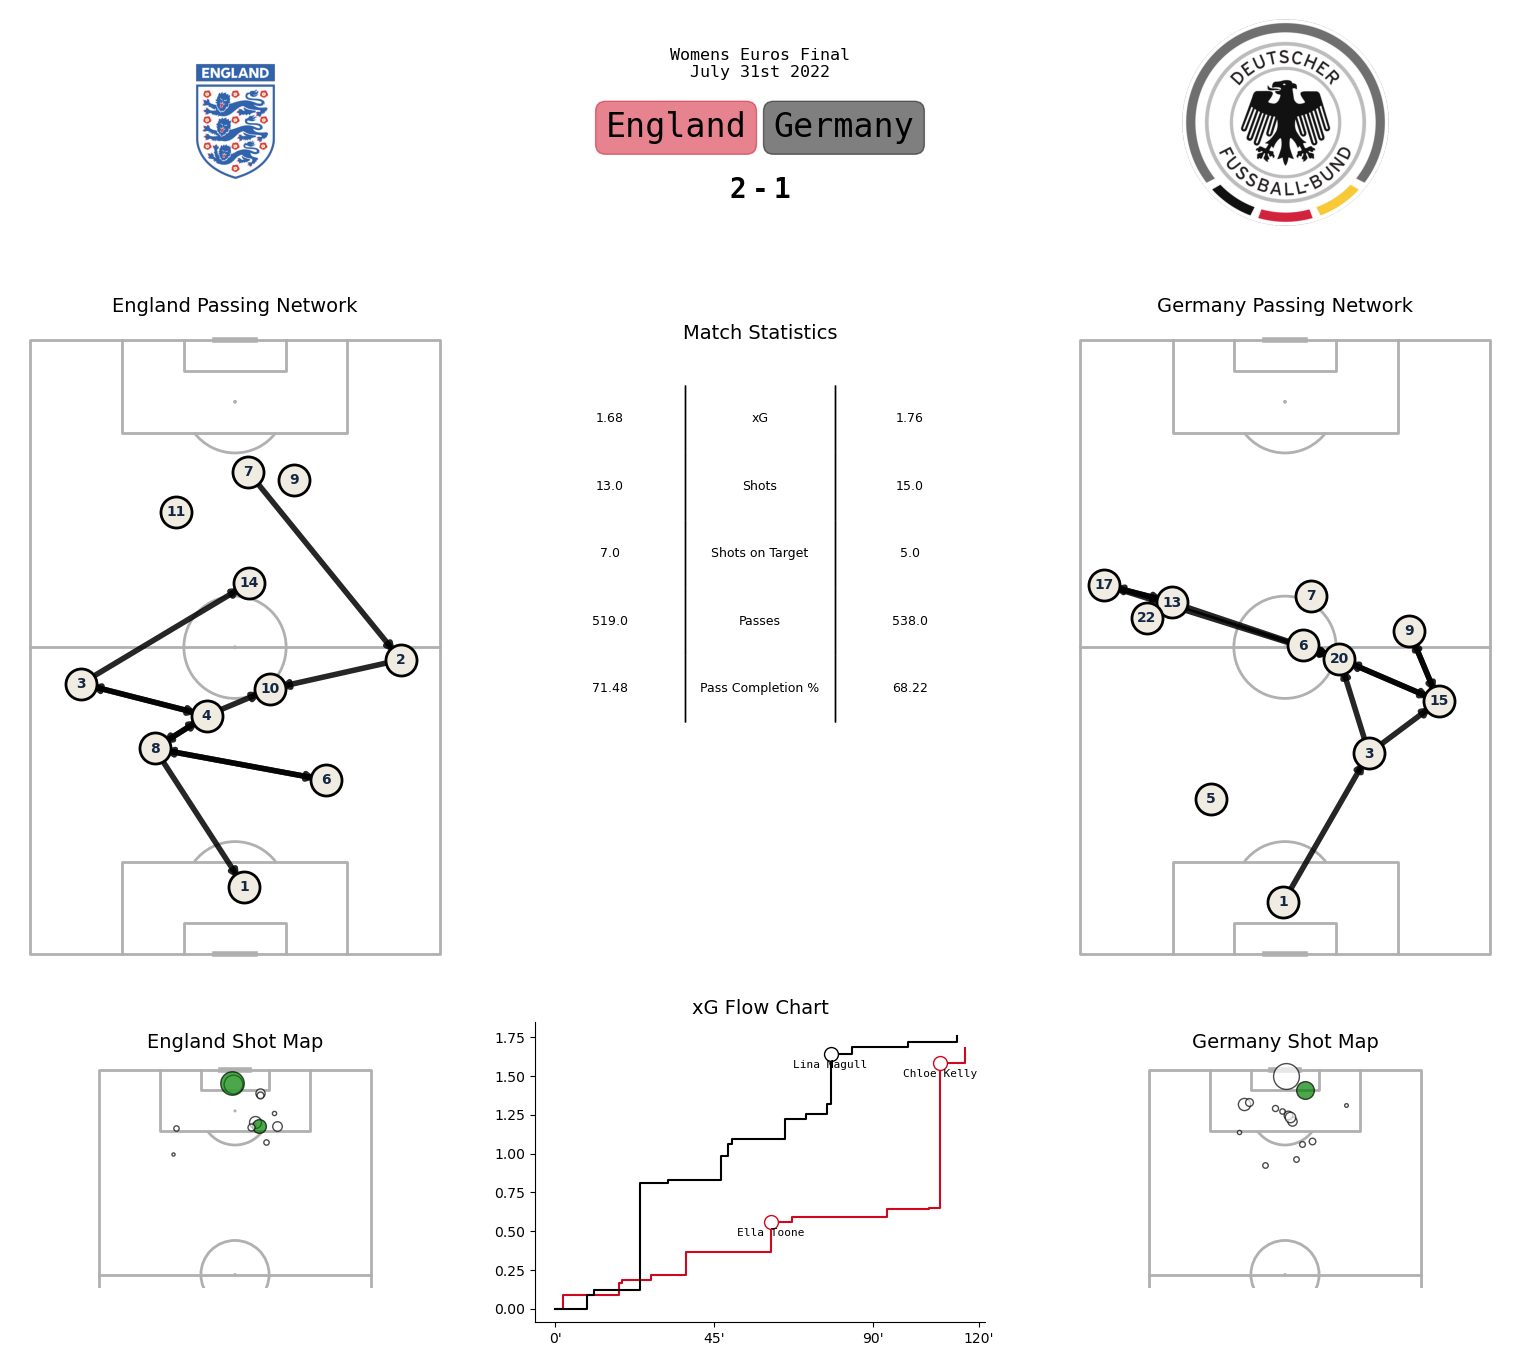

In [10]:
fig = plt.figure(figsize=(15,15))

ax1 = fig.add_axes([0.225, 0.775, 0.15, 0.15])

team1_img = Image.open('/Users/Chloe/Documents/GitHub/complete-football-analytics/team_logos/england_logo.png')
ax1.imshow(team1_img)
ax1.axis('off')


ax2 = fig.add_axes([0.5, 0.8, 0.3, 0.1])

ax2.text(0.5, 0.8, 'Womens Euros Final\nJuly 31st 2022', fontsize=12, ha='center', fontdict={'family': 'monospace'})
team_1_text = ax2.text(0.47, 0.4, 'England', fontsize=24, ha='right',fontdict={'family': 'monospace'})
team_1_text.set_bbox(dict(facecolor=ENGLAND_COLOR, alpha=0.5, edgecolor=ENGLAND_COLOR, boxstyle='round'))

team_2_text = ax2.text(0.53, 0.4, 'Germany', fontsize=24, ha='left',fontdict={'family': 'monospace'})
team_2_text.set_bbox(dict(facecolor=GERMANY_COLOR, alpha=0.5, edgecolor=GERMANY_COLOR, boxstyle='round'))

ax2.text(0.47, 0, '2', fontsize=20, ha='right',fontdict={'family': 'monospace', 'weight': 'bold'})
ax2.text(0.5, 0, '-', fontsize=20, ha='center',fontdict={'family': 'monospace', 'weight': 'bold'})
ax2.text(0.53, 0, '1', fontsize=20, ha='left',fontdict={'family': 'monospace', 'weight': 'bold'})
ax2.axis('off')


ax3 = fig.add_axes([0.925, 0.775, 0.15, 0.15])

team2_img = Image.open('/Users/Chloe/Documents/GitHub/complete-football-analytics/team_logos/germany_logo.webp')
ax3.imshow(team2_img)
ax3.axis('off')


ax4 = fig.add_axes([0.15, 0.25, 0.3, 0.5])
create_passnetwork(team1, ax4)
ax4.set_title('England Passing Network', fontsize=14)

ax5 = fig.add_axes([0.5, 0.2, 0.3, 0.5])
columns_labels, table_vals = create_table(team1, team2)

table = ax5.table(
    cellText=table_vals, 
    cellLoc='center', 
    edges='vertical',
    bbox=[0, .5, 1, .45],
)


table.set_fontsize(14)

for (i, j), cell in table.get_celld().items():
    if j == 0:
        table.get_celld()[(i, j)].visible_edges = 'R'
    elif j == 2:
        table.get_celld()[(i, j)].visible_edges = 'L'
    else:
        table.get_celld()[(i, j)].visible_edges = 'LR'

ax5.axis('off')
ax5.set_title('Match Statistics', fontsize=14)

ax6 = fig.add_axes([0.85, 0.25, 0.3, 0.5])
create_passnetwork(team2, ax6)
ax6.set_title('Germany Passing Network', fontsize=14)

ax7 = fig.add_axes([0.2, 0.05, 0.2, 0.2])
create_shotmap(team1, ax7)
ax7.axis('off')
ax7.set_title('England Shot Map', fontsize=14)

ax8 = fig.add_axes([0.5, 0.05, 0.3, 0.2])
create_xg_flow_chart(df, ax8)
ax8.set_title('xG Flow Chart', fontsize=14)

ax9 = fig.add_axes([0.9, 0.05, 0.2, 0.2])
create_shotmap(team2, ax9)
ax9.axis('off')
ax9.set_title('Germany Shot Map', fontsize=14)

In [11]:
# from requests_cache import clear

# clear()

In [12]:
def get_passing_combinations(team):
    # Extract x and y coordinates
    team[['x', 'y']] = team['location'].apply(pd.Series)
    
    # Extract tactics and jersey numbers
    tactics = team[~team['tactics'].isnull()][['tactics', 'team']]
    all_jersey_numbers = [
        pd.DataFrame([{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']])
        for y in tactics.to_dict(orient='records')
    ]
    jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()
    
    # Create a new time column and sort by time
    team["newsecond"] = 60 * team["minute"] + team["second"]
    team.sort_values(by=['newsecond'], inplace=True)
    
    # Identify the passer and recipient
    team['passer'] = team['player_id']
    team['recipient'] = team['passer'].shift(-1)
    
    # Filter for passes and successful passes
    passes_df = team.loc[team['type'] == "Pass"].copy()
    passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
    completions = passes_df.loc[passes_df['pass_outcome'] == "Successful"]
    
    # Find the time of the team's first substitution and filter the completions
    sub_df = team.loc[team['type'] == "Substitution"]
    first_sub = sub_df["newsecond"].min() if not sub_df.empty else (60 * 45)
    first_sub = first_sub if first_sub > 60 * 45 else 60 * 45
    completions = completions.loc[completions['newsecond'] < first_sub]
    
    # Find average locations
    average_locs_and_count = completions.groupby('passer').agg({'x': 'mean', 'y': 'mean', 'id': 'count'}).reset_index()
    average_locs_and_count.columns = ['passer', 'x', 'y', 'count']
    
    # Find number of passes between each passer and recipient
    passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
    passes_between.rename(columns={'id': 'pass_count'}, inplace=True)
    
    # Merge the average locations for passers and recipients
    passes_between = passes_between.merge(average_locs_and_count[['passer', 'x', 'y']], on='passer')
    passes_between = passes_between.merge(
        average_locs_and_count[['passer', 'x', 'y']], left_on='recipient', right_on='passer', suffixes=('', '_end')
    )
    passes_between = passes_between[['passer', 'recipient', 'pass_count']]
    
    # Add player names or jersey numbers
    passes_between = passes_between.merge(jersey_numbers[['player_id', 'jersey_number']], left_on='passer', right_on='player_id', how='left')
    passes_between = passes_between.merge(jersey_numbers[['player_id', 'jersey_number']], left_on='recipient', right_on='player_id', how='left', suffixes=('_passer', '_recipient'))
    
    # Select relevant columns and rename for clarity
    passes_between = passes_between[['passer', 'recipient', 'pass_count', 'jersey_number_passer', 'jersey_number_recipient']]
    passes_between.rename(columns={'jersey_number_passer': 'passer_jersey_number', 'jersey_number_recipient': 'recipient_jersey_number'}, inplace=True)
    
    # Set a minimum threshold for passes to be included in the table
    passes_between = passes_between.loc[passes_between['pass_count'] >= 4]
    
    # Sort by pass_count in descending order
    passes_between = passes_between.sort_values(by='pass_count', ascending=False)
    
    # Return the resulting DataFrame
    return passes_between

# Assuming 'team' is your DataFrame with the necessary data
passing_combinations = get_passing_combinations(team1)
print(passing_combinations)

     passer  recipient  pass_count  passer_jersey_number  \
17   4658.0    18999.0           6                     4   
26  18999.0     4658.0           6                     8   
32  15619.0    10178.0           6                     7   
16   4642.0    18999.0           5                     6   
24   5058.0     4658.0           5                     3   
49  18999.0     4642.0           5                     8   
52   4658.0     4643.0           4                     4   
53  10178.0     4643.0           4                     2   
61  18999.0     5058.0           4                     8   
64   5058.0     4641.0           4                     3   

    recipient_jersey_number  
17                        8  
26                        4  
32                        2  
16                        8  
24                        4  
49                        6  
52                       10  
53                       10  
61                        3  
64                       14  


In [141]:
# Filter the columns to only shots
df = df[df['type'] == 'Shot']

# Sort the values so they are in order of time (if needed, this step is not necessary for finding the highest xG per team)
df = df.sort_values(by="index")

# Find the index of the row with the highest xG for each team
idx = df.groupby('team_id')['shot_statsbomb_xg'].idxmax()

# Use these indices to filter the original dataframe
highest_xg_per_team = df.loc[idx].reset_index(drop=True)

print(highest_xg_per_team)


  50_50 bad_behaviour_card ball_receipt_outcome ball_recovery_offensive  \
0   NaN                NaN                  NaN                     NaN   
1   NaN                NaN                  NaN                     NaN   

  ball_recovery_recovery_failure block_deflection carry_end_location  \
0                            NaN              NaN                NaN   
1                            NaN              NaN                NaN   

  clearance_aerial_won clearance_body_part clearance_head  ...  \
0                  NaN                 NaN            NaN  ...   
1                  NaN                 NaN            NaN  ...   

  substitution_outcome substitution_outcome_id substitution_replacement  \
0                  NaN                     NaN                      NaN   
1                  NaN                     NaN                      NaN   

  substitution_replacement_id tactics             team team_id     timestamp  \
0                         NaN     NaN  Germany Women

In [142]:
# Filter the columns to only shots
df = df[df['type'] == 'Shot']

# Sort the values so they are in order of time (optional, as this step is not necessary for finding the highest xG per team)
df = df.sort_values(by="index")

# Find the index of the row with the highest xG for each team
idx = df.groupby('team_id')['shot_statsbomb_xg'].idxmax()

# Use these indices to filter the original dataframe and include the player information
highest_xg_per_team = df.loc[idx, ['team_id', 'player', 'shot_statsbomb_xg']].reset_index(drop=True)

print(highest_xg_per_team)


   team_id           player  shot_statsbomb_xg
0      857  Marina Hegering           0.691022
1      865      Chloe Kelly           0.571714


In [155]:
# Filter the columns to only shots
df = df[df['type'] == 'Shot']

# Sort the values so they are in order of time (optional, as this step is not necessary for finding the highest xG per team)
df = df.sort_values(by="index")

# Group by team_id and then apply a lambda function to get the top 5 xG shots for each team
top_10_xg_per_team = df.groupby('team_id').apply(lambda x: x.nlargest(10, 'shot_statsbomb_xg')).reset_index(drop=True)

# Select relevant columns (including player_name and time of the shot)
top_10_xg_per_team = top_10_xg_per_team[['team_id', 'player', 'shot_statsbomb_xg', 'timestamp']]

print(top_10_xg_per_team)


    team_id           player  shot_statsbomb_xg     timestamp
0       857  Marina Hegering           0.691022  00:24:54.607
1       857      Lina Magull           0.325488  00:33:42.576
2       857    Tabea Waßmuth           0.154616  00:02:09.653
3       857     Lea Schüller           0.113194  00:20:22.460
4       857     Sara Däbritz           0.089770  00:09:18.826
5       857      Lina Magull           0.078365  00:04:03.351
6       857      Lina Magull           0.063375  00:32:55.980
7       857    Tabea Waßmuth           0.045020  00:39:17.754
8       857    Lena Oberdorf           0.038222  00:09:00.702
9       857      Lina Magull           0.034208  00:26:05.718
10      865      Chloe Kelly           0.571714  00:04:53.605
11      865      Chloe Kelly           0.364242  00:04:52.741
12      865       Ella Toone           0.197169  00:16:32.374
13      865      Ellen White           0.148702  00:37:55.435
14      865    Alessia Russo           0.094719  00:11:02.128
15      

In [159]:
# Filter the dataframe to only include shots
df_shots = df[df['type'] == 'Shot']

# # Sort the values so they are in order of time (optional)
# df_shots = df_shots.sort_values(by="index")

# Sort the values by shot_statsbomb_xg in descending order
df_shots = df_shots.sort_values(by='shot_statsbomb_xg', ascending=False)

# Select relevant columns (including player_name and time of the shot)
df_shots = df_shots[['team_id', 'player', 'shot_statsbomb_xg', 'timestamp']]

print(df_shots)


      team_id           player  shot_statsbomb_xg     timestamp
3513      857  Marina Hegering           0.691022  00:24:54.607
3532      865      Chloe Kelly           0.571714  00:04:53.605
3531      865      Chloe Kelly           0.364242  00:04:52.741
3526      857      Lina Magull           0.325488  00:33:42.576
3520      865       Ella Toone           0.197169  00:16:32.374
3517      857    Tabea Waßmuth           0.154616  00:02:09.653
3516      865      Ellen White           0.148702  00:37:55.435
3522      857     Lea Schüller           0.113194  00:20:22.460
3534      865    Alessia Russo           0.094719  00:11:02.128
3508      857     Sara Däbritz           0.089770  00:09:18.826
3507      865      Ellen White           0.087262  00:02:59.591
3518      857      Lina Magull           0.078365  00:04:03.351
3525      857      Lina Magull           0.063375  00:32:55.980
3528      865    Millie Bright           0.050924  00:04:21.307
3511      865      Lucy Bronze          

---

**Read the full article on my Substack: [Beyond the Touchline - Reliving the 2022 Women's Euro Championship Final](https://beyondthetouchline.substack.com/p/reliving-the-2022-womens-euro-championship?r=3gmn6f)**

_This notebook contains the code and analysis behind the article._

---